# Topic Modeling (Prepare)

On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are often not explicitly called out and labeled in the document corpus. So some extra work is needed to figure out the topics. Today we will learn a powerful technique for doing this (almost) automatically!

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: What the are your documents about? <br>
What are some industrial applications?
* Identifying common themes in customer reviews
* Grouping job ads into categories 
* Sorting customer inquiries into categories so they can be routed to the appropriate department for processing.
* Monitoring communications (Email - State Department, Google) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* Part 1: Describe how a Latent Dirichlet Allocation (LDA) Model works
* Part 2: Build a LDA Model with Gensim
* Part 3: Interpret LDA results & Select an appropriate number of topics

##1.0 Setup

##1.0.1 Get spacy

In [ ]:
# could use *web_lg or *web_sm instead
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.2 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=14bf8eebd39a16761a3127c87468df040d8e5fe779b2c2de4a759207f4000d31
  Stored in directory: /tmp/pip-ephem-wheel-cache-e6xg9rmi/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


## 1.0.1 Restart runtime!
On Colab, we need to restart runtime after this step, <br>
or else Colab won't find spacy!

##1.0.2 Install dependencies

In [ ]:
# Dependencies for the week (instead of conda)
# Run if you're using colab, otherwise you should have a local copy of the data
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
!pip install -r requirements.txt

--2021-09-30 15:12:41--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     149  --.-KB/s    in 0s      

2021-09-30 15:12:42 (9.11 MB/s) - ‘requirements.txt’ saved [149/149]

     |████████████████████████████████| 24.2 MB 1.3 MB/s 
     |████████████████████████████████| 1.6 MB 55.7 MB/s 
     |████████████████████████████████| 10.4 MB 32.5 MB/s 
     |████████████████████████████████| 7.1 MB 12.4 MB/s 
     |████████████████████████████████| 208 kB 59.8 MB/s 
     |████████████████████████████████| 2.2 MB 52.3 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-p

##1.0.3 Imports and such

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.datasets import fetch_20newsgroups
from pandarallel import pandarallel

import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Part 1: Describe how an LDA Model works

We are going to focus on a high level of understand for how LDA works, meaning we are going to focus on "what it does" instead of "how it does it". I realize that this may be unsatisfying to some so I've included some resources that serve as a prerequisite for understanding how LDA works at a mathematical level. 

LDA is a [**Probabilistic Graphical Model (PGM)**](https://en.wikipedia.org/wiki/Graphical_model)

PGM are represented by a graph that expresses the conditional dependence structure between random variables. Here's the LDA representation dependency graph: 

![](https://filebox.ece.vt.edu/~s14ece6504/projects/alfadda_topic/main_figure_3.png)

These image is communicating the hierarchical dependency between probability distributions and their parameters. This is an application of Bayesian Probability - on steroids. 


In order to understand how LDA works, one must first understand how PGMs work, which is beyond the scope of Unit 4. If this is something that you're interested in learning more about, here are some resources: 

This Github repo that has transformed a textbook in a collection of Jupyter Notebooks. This repo is called [**"Bayesian Methods for Hackers"**](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) <br>
The cool thing about this repo is that each chapter covers the same material using popular python probabilistic modeling libraries: **PyMC2, PyMC3, Pyro, and Tensorflow Probability.** So you can choose your preferred library.

Having said that, [**Pyro**](https://pyro.ai/) is considered a very powerful probabilistic programming library that even combines probabilistic programming with deep learning. 

### Resources for LDA

[**Your Guide to Latent Dirichlet Allocation**](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d) is a highly recommended medium article that works through an example of LDA in elementary terms

[**LDA Topic Modeling**](https://lettier.com/projects/lda-topic-modeling/)This is an interactive data visualization tool that allows us to explore a simple and visual example of LDA. It was created by the author of the above article! We'll be using this to learn about LDA in class. 

[**Topic Modeling with Gensim**](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) This is an example of implementing LDA using the same dataset that we are using in the guided project.  

# Problem Statement

We are going to load some emails from the same `20newsgroups` data familiar from Module 3, except we'll extract emails from a different set of categories.

Those emails, belong to topics -- however the topics are hierarchical.

    sci
        \_ electronics, space


    talk
        \_politics 
                  \_ guns, middle east
              
So what's the best way to categorize these emails - is it between science and talk? 

Is it between electronics, space, guns, and the Middle East? 

The Middle East is a pretty broad topics in and of itself, should that topic be broken down into further sub-topics?

Let's learn about Topic Modeling and how it can help us answer this questions!

### Load Email Corpus


In [ ]:
# notice that the categories are hierarchical
# so there is a sense in which we have 2 topics, but also as many as 4 topics  
categories = ['sci.electronics', 'sci.space', 
              'talk.politics.guns', 'talk.politics.mideast']
data = fetch_20newsgroups(categories=categories)

In [ ]:
# create X and y from data, as we did in Module 3

###BEGIN SOLUTION
X = data.data
y = data.target
target_names = data.target_names
###END SOLUTION

What are the possible targets (labels)

In [ ]:
np.unique(y)

array([0, 1, 2, 3])

What are the newsgroup names that correspond to the labels?

In [ ]:
target_names

['sci.electronics', 'sci.space', 'talk.politics.guns', 'talk.politics.mideast']

Create a data frame with columns for the documents, the newsgroup names, and their numerical labels.

In [ ]:
data = {
    'content': X,
    'target': y,
    'target_names': [target_names[target_index] for target_index in y]
}

df = pd.DataFrame(data=data)

In [ ]:
df.head()

,content,target,target_names
0,From: webb@itu1 (90-29265 Webber AH)\nSubjec...,0,sci.electronics
1,From: nate@psygate.psych.indiana.edu (Nathan E...,2,talk.politics.guns
2,"From: ab4z@Virginia.EDU (""Andi Beyer"")\nSubjec...",3,talk.politics.mideast
3,"From: levy@levy.fnal.gov (Mark E. Levy, ext. 8...",0,sci.electronics
4,From: wolfone@ccwf.cc.utexas.edu (I am an andr...,2,talk.politics.guns


Re-use our `clean_data()` helper function from Module 3.

In [ ]:
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document. 
    
    Parameters
    ----------
    text: string or object 
    
    Returns
    -------
    text: string or object
    """
    
    # order of operations - apply the expression from top to bottom
    email_regex = "From: \S*@\S*\s?"
    non_alpha = '[^a-zA-Z]'
    multi_white_spaces = "[ ]{2,}"
    
    text = re.sub(email_regex, "", text)
    text = re.sub(non_alpha, ' ', text)
    text = re.sub(multi_white_spaces, " ", text)
    
    # apply case normalization 
    return text.lower().lstrip().rstrip()

Clean the text string data and save it in a new column

In [ ]:
df["clean_data"] = df["content"].apply(clean_data)

In [ ]:
df.head()

,content,target,target_names,clean_data
0,From: webb@itu1 (90-29265 Webber AH)\nSubjec...,0,sci.electronics,webber ah subject re adcom cheap products arti...
1,From: nate@psygate.psych.indiana.edu (Nathan E...,2,talk.politics.guns,nathan engle subject re atf burns dividian ran...
2,"From: ab4z@Virginia.EDU (""Andi Beyer"")\nSubjec...",3,talk.politics.mideast,andi beyer subject re israeli terrorism organi...
3,"From: levy@levy.fnal.gov (Mark E. Levy, ext. 8...",0,sci.electronics,mark e levy ext subject sources for intel d c ...
4,From: wolfone@ccwf.cc.utexas.edu (I am an andr...,2,talk.politics.guns,i am an android subject re atf burns dividian ...


### Create Tokens 

Before we can use the `gensim` library to create bag-of-words vectors in exactly the right way that the LDA model wants, we must first create tokens. 

Let's use spaCy to create some lemmas. But first let's initialize our multi-processing library `pandarallel` which will empower us to use the same dataframe that our data is stored in but be able to create tokens in parallel so as to save time.

Here's the documentation for [**pandarallel**](https://github.com/nalepae/pandarallel)

In [ ]:
# we must initalize pandarallel before we can use it
pandarallel.initialize(progress_bar=True, nb_workers=10)
# so that the progress bars will work
from pandarallel.utils import progress_bars
progress_bars.is_notebook_lab = lambda : True


INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
# load in our spaCy language model
nlp = spacy.load("en_core_web_md")

In [ ]:
%%time
# create our tokens in the form of lemmas 
# parallel_apply takes about 2 min on Colab
#df['lemmas'] = df['clean_data'].parallel_apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])
# parallel_map takes about 50 sec
df['lemmas'] = df['clean_data'].parallel_map(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])

CPU times: user 3.12 s, sys: 618 ms, total: 3.73 s
Wall time: 52.1 s


### Take a look at our lemmas

In [ ]:
df['clean_data'][0]

'webber ah subject re adcom cheap products article i d hippo apr organization rhodes university grahamstown south africa lines x newsreader tin version pl i want to upgrade my system and was thinking of buying adcom seperates i have heard from alot of people though that adcom sounds great but that the components are made cheaply and therefore won t last very long the time estimates i ve heard are like only or years is this true i own the adcom w power amp as far as i m concerned there s no amp which can touch it at the price range the build quality is very impressive and is far superior to other amps in the price range the whole amplifier is extremely solid with massive heat sinks and very solid casing if you open the amp up there are only very good quality components in and the amp seems to be designed extremely well perfect symmetry for both channels and two transformers one for each channel the binding posts on the back of the amplifier are virtually the same as those on the classe 

In [ ]:
# print out the lemmas from the first article
df['lemmas'][0]

['webber',
 'ah',
 'subject',
 'adcom',
 'cheap',
 'product',
 'article',
 'd',
 'hippo',
 'apr',
 'organization',
 'rhodes',
 'university',
 'grahamstown',
 'south',
 'africa',
 'lines',
 'x',
 'newsreader',
 'tin',
 'version',
 'pl',
 'want',
 'upgrade',
 'system',
 'think',
 'buy',
 'adcom',
 'seperate',
 'hear',
 'alot',
 'people',
 'adcom',
 'sound',
 'great',
 'component',
 'cheaply',
 'win',
 't',
 'long',
 'time',
 'estimate',
 've',
 'hear',
 'like',
 'year',
 'true',
 'adcom',
 'w',
 'power',
 'amp',
 'far',
 'm',
 'concern',
 's',
 'amp',
 'touch',
 'price',
 'range',
 'build',
 'quality',
 'impressive',
 'far',
 'superior',
 'amp',
 'price',
 'range',
 'amplifier',
 'extremely',
 'solid',
 'massive',
 'heat',
 'sink',
 'solid',
 'casing',
 'open',
 'amp',
 'good',
 'quality',
 'component',
 'amp',
 'design',
 'extremely',
 'perfect',
 'symmetry',
 'channel',
 'transformer',
 'channel',
 'bind',
 'post',
 'amplifier',
 'virtually',
 'classe',
 'model',
 'ie',
 'good',
 'scep

### Filter out low quality lemmas
1 or 2 characters

In [ ]:
def filter_lemmas(lemmas):
    """
    Filter out any lemmas that are 2 characters or smaller
    """
    return [lemma for lemma in lemmas if len(lemma) > 2]

In [ ]:
# apply filter_lemmas
# YOUR CODE HERE
df["filtered_lemmas"] = df["lemmas"].parallel_map(filter_lemmas)

In [ ]:
df["filtered_lemmas"][0]

['webber',
 'subject',
 'adcom',
 'cheap',
 'product',
 'article',
 'hippo',
 'apr',
 'organization',
 'rhodes',
 'university',
 'grahamstown',
 'south',
 'africa',
 'lines',
 'newsreader',
 'tin',
 'version',
 'want',
 'upgrade',
 'system',
 'think',
 'buy',
 'adcom',
 'seperate',
 'hear',
 'alot',
 'people',
 'adcom',
 'sound',
 'great',
 'component',
 'cheaply',
 'win',
 'long',
 'time',
 'estimate',
 'hear',
 'like',
 'year',
 'true',
 'adcom',
 'power',
 'amp',
 'far',
 'concern',
 'amp',
 'touch',
 'price',
 'range',
 'build',
 'quality',
 'impressive',
 'far',
 'superior',
 'amp',
 'price',
 'range',
 'amplifier',
 'extremely',
 'solid',
 'massive',
 'heat',
 'sink',
 'solid',
 'casing',
 'open',
 'amp',
 'good',
 'quality',
 'component',
 'amp',
 'design',
 'extremely',
 'perfect',
 'symmetry',
 'channel',
 'transformer',
 'channel',
 'bind',
 'post',
 'amplifier',
 'virtually',
 'classe',
 'model',
 'good',
 'sceptical',
 'amp',
 'build',
 'far',
 'east',
 'look',
 'amp',
 'co

Overwrite `lemmas` with `filtered_lemmas`

In [ ]:
df['lemmas'] = df["filtered_lemmas"]

### The two main inputs to the LDA topic model are the dictionary (`id2word`) and the corpus.
`id2word` is a special object created by `gensim` that keeps track of the mapping from text to numerical index, and the mapping from numerical index back to text <br>
The `corpus` is a specially formatted list containing information about each document. Though its format is different, is essentially equivalent to the document-term matrix that we used with `sklearn`

In [ ]:
# 1. Create Dictionary

# 2. Term Document Frequency

#  (token id, token count) for each doc in the corpus

# 3. Human readable format of corpus (term-frequency)


### BEGIN SOLUTION
# 1. Create Dictionary from the corpus
id2word = corpora.Dictionary(df['lemmas'])

In [ ]:
id2word

Use the `id2word.doc2bow()` method to process the first document into a list of word counts

In [ ]:
id2word.doc2bow(df['lemmas'][0])

[(0, 7),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 9),
 (5, 5),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 2),
 (13, 3),
 (14, 1),
 (15, 1),
 (16, 2),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 4),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 2),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 2),
 (33, 1),
 (34, 3),
 (35, 1),
 (36, 3),
 (37, 1),
 (38, 1),
 (39, 2),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 2),
 (48, 5),
 (49, 1),
 (50, 2),
 (51, 1),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 1),
 (57, 1),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 1),
 (62, 2),
 (63, 1),
 (64, 1),
 (65, 2),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 2),
 (70, 1),
 (71, 3),
 (72, 2),
 (73, 1),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 2),
 (84, 5),
 (85, 1),
 (86, 1),
 (87, 1),
 (88, 2),
 (89, 1),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 1),
 (94, 1),
 (95, 1),
 (96, 2),
 (97, 1),
 (98, 1),
 (99, 1),
 (100, 1),

process all the documents using a list comprehension

In [ ]:
# 2. Term Document Frequency

# We want a list of (token id, token count) for each doc in the corpus

# Term Document Frequency -- different format, but equivalent in function to the document-term matrix we used in sklearn
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

# corpus stores (token id, token count) for each doc in the corpus
doc_id = 5
corpus[doc_id]

[(9, 3),
 (27, 1),
 (36, 1),
 (39, 1),
 (46, 3),
 (49, 1),
 (60, 1),
 (62, 2),
 (65, 1),
 (87, 1),
 (90, 1),
 (93, 1),
 (102, 1),
 (109, 2),
 (122, 1),
 (128, 2),
 (132, 3),
 (141, 1),
 (147, 4),
 (150, 5),
 (152, 1),
 (155, 3),
 (156, 1),
 (171, 1),
 (174, 1),
 (184, 1),
 (197, 3),
 (206, 1),
 (209, 1),
 (219, 2),
 (296, 5),
 (301, 4),
 (319, 1),
 (326, 2),
 (334, 2),
 (345, 1),
 (349, 2),
 (350, 1),
 (351, 2),
 (352, 1),
 (353, 2),
 (354, 1),
 (355, 1),
 (356, 2),
 (357, 1),
 (358, 2),
 (359, 2),
 (360, 1),
 (361, 2),
 (362, 2),
 (363, 4),
 (364, 1),
 (365, 1),
 (366, 2),
 (367, 2),
 (368, 2),
 (369, 1),
 (370, 2),
 (371, 1),
 (372, 1),
 (373, 1),
 (374, 1),
 (375, 2),
 (376, 1),
 (377, 1),
 (378, 1),
 (379, 1),
 (380, 1),
 (381, 1),
 (382, 3),
 (383, 1),
 (384, 3),
 (385, 2),
 (386, 1),
 (387, 2),
 (388, 1),
 (389, 1),
 (390, 1),
 (391, 2),
 (392, 2),
 (393, 1),
 (394, 1),
 (395, 1),
 (396, 1),
 (397, 2),
 (398, 5),
 (399, 2),
 (400, 4),
 (401, 2),
 (402, 1),
 (403, 2),
 (404, 1),
 

In [ ]:

### BEGIN SOLUTION

# 3. Human readable format of corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[doc_id]]

### END SOLUTION

[('article', 3),
 ('drop', 1),
 ('good', 1),
 ('hear', 1),
 ('inside', 3),
 ('lines', 1),
 ('organization', 1),
 ('people', 2),
 ('point', 1),
 ('subject', 1),
 ('sure', 1),
 ('think', 1),
 ('true', 1),
 ('want', 2),
 ('believe', 1),
 ('child', 2),
 ('come', 3),
 ('distribution', 1),
 ('edu', 4),
 ('fbi', 5),
 ('fire', 1),
 ('get', 3),
 ('host', 1),
 ('nntp', 1),
 ('place', 1),
 ('set', 1),
 ('write', 3),
 ('doubt', 1),
 ('happen', 1),
 ('truth', 2),
 ('com', 5),
 ('day', 4),
 ('let', 1),
 ('news', 2),
 ('stay', 2),
 ('way', 1),
 ('action', 2),
 ('affair', 1),
 ('agree', 2),
 ('alive', 1),
 ('american', 2),
 ('ample', 1),
 ('apparently', 1),
 ('april', 2),
 ('arlen', 1),
 ('arm', 2),
 ('arras', 2),
 ('bastard', 1),
 ('batf', 2),
 ('bill', 2),
 ('bleed', 4),
 ('blind', 1),
 ('bungle', 1),
 ('chatham', 2),
 ('choose', 2),
 ('chopin', 2),
 ('clem', 1),
 ('clinton', 2),
 ('comment', 1),
 ('common', 1),
 ('compound', 1),
 ('congress', 1),
 ('country', 2),
 ('course', 1),
 ('creature', 1),
 

# Part 2: Estimate a Latent Dirichlet Allocation (LDA) Model with `gensim`

 ### Train an LDA model

In [ ]:
### This cell runs the single-processor version of the model (slower)
# %%time
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            chunksize=100,
#                                            passes=10,
#                                            per_word_topics=True)
# lda_model.save('lda_model.model')
# # https://radimrehurek.com/gensim/models/ldamodel.html

In [ ]:
%%time

num_topics = 2
### This cell runs the multi-processor version of the model (faster)
lda_multicore_2_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,# runtime related parameter
                                                        per_word_topics=True,
                                                        workers=10, # runtime related parameter
                                                        random_state=1234, 
                                                        iterations=20) # runtime related parameter

num_topics = 6
### This cell runs the multi-processor version of the model (faster)
lda_multicore_6_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,# runtime related parameter
                                                        per_word_topics=True,
                                                        workers=10, # runtime related parameter
                                                        random_state=1234, 
                                                        iterations=20) # runtime related parameter

CPU times: user 19.6 s, sys: 2.67 s, total: 22.3 s
Wall time: 21.3 s


# Part 3: Interpret LDA results & Select the appropriate number of topics
We will use the `pyLDAvis` library which implements [LDAvis](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) in `python`.<br>
LDAvis provides an interactive visualization of the topics estimated using Latent Dirichlet Allocation (LDA).<br>

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_2_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster     Freq
topic                                         
0      0.121026  0.0       1        1  58.7752
1     -0.121026  0.0       2        1  41.2248, topic_info=          Term         Freq        Total Category  logprob  loglift
620      space  1467.000000  1467.000000  Default  30.0000  30.0000
484        gun  1300.000000  1300.000000  Default  29.0000  29.0000
611       nasa   599.000000   599.000000  Default  28.0000  28.0000
1391    israel   888.000000   888.000000  Default  27.0000  27.0000
922   armenian   888.000000   888.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
160       know   456.017720  1388.859429   Topic2  -5.8695  -0.2276
143        don   424.376870  1275.614703   Topic2  -5.9414  -0.2144
256       need   345.823020   611.659261   Topic2  -6.1461   0.3159
8          apr   372.575090   996.716359   Topic2  -6.0716  -0.0979
114       year   364.927211   918.121126   Topic2  -6.0923  -0.0365

[173 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1098       1  0.013473   alaska
1098       2  0.983493   alaska
3678       1  0.006625  antenna
3678       2  0.993766  antenna
8          1  0.626056      apr
...      ...       ...      ...
197        1  0.633325    write
197        2  0.366427    write
26735      1  0.999015  yalanci
114        1  0.602317     year
114        2  0.397551     year

[255 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_6_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.093425  0.022933       1        1  33.374865
5      0.095656  0.047912       2        1  18.303558
2     -0.166251 -0.123105       3        1  15.144470
1      0.174966 -0.119251       4        1  13.160740
3     -0.053922  0.097143       5        1  12.205558
4      0.042976  0.074368       6        1   7.810809, topic_info=           Term         Freq        Total Category  logprob  loglift
620       space  1373.000000  1373.000000  Default  30.0000  30.0000
968     turkish   621.000000   621.000000  Default  29.0000  29.0000
484         gun  1543.000000  1543.000000  Default  28.0000  28.0000
147         edu  3331.000000  3331.000000  Default  27.0000  27.0000
922    armenian   648.000000   648.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
296         com   103.418536  1623.639957   Topic6  -5.6897  -0.2040
616    question    87.250193   803.737715   Topic6  -5.8597   0.3292
48         like    93.561106  1400.594854   Topic6  -5.7899  -0.1564
103  university    80.122272  1079.212622   Topic6  -5.9449  -0.0508
143         don    73.971007  1345.000876   Topic6  -6.0248  -0.3508

[492 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
5440      1  0.967298    abide
5440      5  0.019346    abide
1096      2  0.967908     acad
1443      1  0.153123   access
1443      2  0.545917   access
...     ...       ...      ...
1005      4  0.045996      zoo
1005      5  0.009199      zoo
1006      2  0.985038  zoology
971       1  0.012340     zuma
971       3  0.987197     zuma

[1256 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 3, 2, 4, 5])

## What is topic coherence?
Topic Coherence measures score a single topic by **measuring the degree of semantic similarity between high scoring words in the topic**. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.


A set of statements or facts is said to be **coherent**, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is **“the game is a team sport”**, **“the game is played with a ball”**, **“the game demands great physical efforts”**


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
%%time
# takes about 3 min
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['lemmas'], start=2, limit=10, step=1)

CPU times: user 2min 35s, sys: 8.82 s, total: 2min 44s
Wall time: 4min 25s


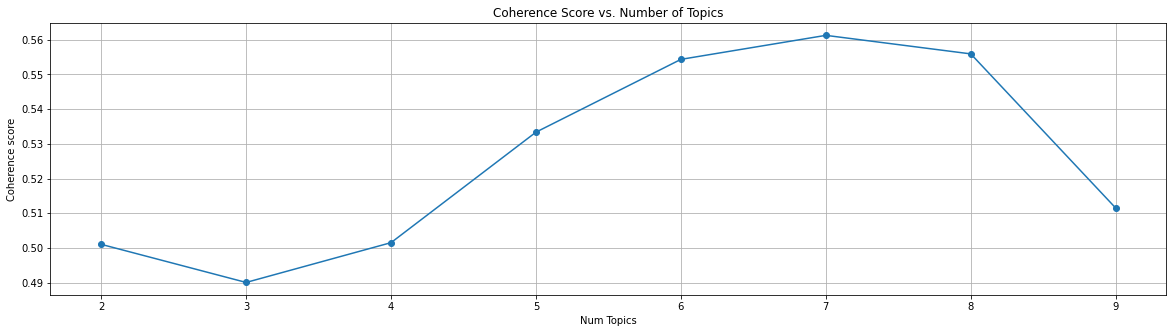

In [ ]:
start=2; limit=10;  step=1;
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

### Index for Model 

Due to the probabilistic nature of this model, the modeling results can and usually do vary. Despite this, we will select 8 as the number of topics even if this particular model run doesn't show 8 as having the highest coherence score. Also, even if it doesn't, we  need to ask ourselves how many topics we actually want for our corpus. 

In [ ]:
lda_trained_model = model_list[-2]

In [ ]:
lda_trained_model

In [ ]:
# visualize the topics 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_trained_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.146577 -0.037309       1        1  33.350255
3     -0.108785  0.075936       2        1  14.716959
7      0.077843 -0.002905       3        1  11.681221
6      0.076845  0.022020       4        1   8.783035
2     -0.153305 -0.105913       5        1   8.664352
5      0.054477  0.075702       6        1   8.657535
1      0.166594 -0.135607       7        1   7.703312
4      0.032907  0.108076       8        1   6.443331, topic_info=           Term         Freq        Total Category  logprob  loglift
620       space  1402.000000  1402.000000  Default  30.0000  30.0000
968     turkish   706.000000   706.000000  Default  29.0000  29.0000
922    armenian   802.000000   802.000000  Default  28.0000  28.0000
147         edu  3376.000000  3376.000000  Default  27.0000  27.0000
1008  armenians   627.000000   627.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
260     problem    70.072441   605.705064   Topic8  -5.8865   0.5853
296         com    69.898567  1582.741992   Topic8  -5.8890  -0.3777
172      number    62.710569   600.243965   Topic8  -5.9975   0.4833
156        host    64.253601   990.033128   Topic8  -5.9732   0.0072
171        nntp    63.553683   961.711113   Topic8  -5.9841   0.0253

[670 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1096      4  0.192206     acad
1096      6  0.788044     acad
1443      1  0.023356   access
1443      2  0.093422   access
1443      3  0.330314   access
...     ...       ...      ...
1005      4  0.213190      zoo
1005      6  0.629418      zoo
1006      3  0.052640  zoology
1006      4  0.065800  zoology
1006      6  0.868564  zoology

[1951 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 8, 7, 3, 6, 2, 5])

## Create a Topic id/name dictionary 

When populating your topic id/name dictionary, use the index ordering as shown in the viz tool. 

We'll use a function to map the the viz tool index ordering with the train LDA model ordering. 

In [ ]:
# keys - use topic ids from pyLDAvis visualization 
# values - topic names that you create 
# save dictionary to `vis_topic_name_dict`
###BEGIN SOLUTION
# this is the results from a model run however these topic names might not make sense in future model runs
# thus these names will likely have to be thought through during each lecture 
vis_topic_name_dict = {1:"Guns", 
                       2:"Armenian_Turkish_Conflict", 
                       3:"Armenian_Turkish_Conflict", 
                       4:"Isreal", 
                       5:"Space", 
                       6:"Space", 
                       7:"Space", 
                       8:"Space"}
###END SOLUTION

## Create a topic id lookup dictionary

In [ ]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    """
    Both the starting index and the ordering of topic ids bewteen the trained LDA model 
    and the viz tool are different. So we need to create a look up dictionary that maps 
    the correct association between topic ids from both sources. 
    """
    # value is order of topic ids according to pyLDAvis tool 
    # key is order of topic ids according to lda model
    model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()

    # invert dictionary so that 
    # key is order of topic ids accoridng to pyLDAvis tool 
    # value is order of topic ids according to lda model
    topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}
    
    # iterate through topic_id_lookup and index vis_topic_name_dict using the keys 
    # in order to swap the viz topic ids in vis_topic_name_dict for the lda model topic ids 
    return {v:vis_topic_name_dict[k]  for k, v in topic_id_lookup.items()}

In [ ]:
###BEGIN SOLUTION
# now we have an updated topic id/name dict
# the topic ids correspond to how the lda model has index the topics 
# now we can use this dictionary with lda model to label our docs 
topic_name_dict = get_topic_id_lookup_dict(vis, vis_topic_name_dict)
###END SOLTUION

In [ ]:
topic_name_dict

{0: 'Guns',
 1: 'Space',
 2: 'Space',
 3: 'Armenian_Turkish_Conflict',
 4: 'Space',
 5: 'Space',
 6: 'Isreal',
 7: 'Armenian_Turkish_Conflict'}

## Assign Each Document a Topic Name

Now that we have a topic id/name look up dict that is aligned with the index ordering of the trained LDA model, we can move forward to giving each topic a topic name. 

This function iterates over the documents in a corpus and outputs a list with the topic ID -- according to the trained `lda_model` -- of the highest-probability topic for each document

The function below has been given to you. However, you highly encouraged to read through it and make sure that you understand what it is doing each step of the way. In fact, a good way to do this is to copy and paste the code inside of the function into a new cell, comment out all the lines of code and line by line, uncomment the code and see the output. 

In [ ]:
def get_topic_ids_for_docs(lda_model, corpus):
    
    """
    Passes a Bag-of-Words vector into a trained LDA model in order to get the topic id of that document. 
    
    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model 
        
    corpus: nested lists of tuples, 
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]
        
    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus 
    """
    
    # store topic ids for each document
    doc_topic_ids = []

    # iterature through the bow vectors for each doc
    for doc_bow in corpus:
        
        # store the topic ids for the doc
        topic_ids = []
        # store the topic probabilities for the doc
        topic_probs = []

        # list of tuples
        # each tuple has a topic id and the prob that the doc belongs to that topic 
        topic_id_prob_tuples = lda_trained_model.get_document_topics(doc_bow)
        
        # iterate through the topic id/prob pairs 
        for topic_id_prob in topic_id_prob_tuples:
            
            # index for topic id
            topic_id = topic_id_prob[0]
            # index for prob that doc belongs that the corresponding topic
            topic_prob = topic_id_prob[1]

            # store all topic ids for doc
            topic_ids.append(topic_id)
            # store all topic probs for doc
            topic_probs.append(topic_prob)

        # get index for largest prob score
        max_topic_prob_ind = np.argmax(topic_probs)
        # get corresponding topic id
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        # store topic id that had the highest prob for doc being a memebr of that topic
        doc_topic_ids.append(max_prob_topic_id)
        
    return doc_topic_ids

In [ ]:
# get the topic id for each doc in the corpus 
topic_id_list = get_topic_ids_for_docs(lda_trained_model, corpus)

# create a feature for document's topic id
df["topic_id"] = topic_id_list

# iterate through the topic id and use the lookup table to assign each document with a topic name
df["new_topic_name"] = df["topic_id"].apply(lambda topic_id: topic_name_dict[topic_id])

In [ ]:
# cool! so now all of our documents have topic ids and names 
df.head()

,content,target,target_names,clean_data,lemmas,filtered_lemmas,topic_id,new_topic_name
0,From: webb@itu1 (90-29265 Webber AH)\nSubjec...,0,sci.electronics,webber ah subject re adcom cheap products arti...,"[webber, subject, adcom, cheap, product, artic...","[webber, subject, adcom, cheap, product, artic...",5,Space
1,From: nate@psygate.psych.indiana.edu (Nathan E...,2,talk.politics.guns,nathan engle subject re atf burns dividian ran...,"[nathan, engle, subject, atf, burns, dividian,...","[nathan, engle, subject, atf, burns, dividian,...",3,Armenian_Turkish_Conflict
2,"From: ab4z@Virginia.EDU (""Andi Beyer"")\nSubjec...",3,talk.politics.mideast,andi beyer subject re israeli terrorism organi...,"[andi, beyer, subject, israeli, terrorism, org...","[andi, beyer, subject, israeli, terrorism, org...",3,Armenian_Turkish_Conflict
3,"From: levy@levy.fnal.gov (Mark E. Levy, ext. 8...",0,sci.electronics,mark e levy ext subject sources for intel d c ...,"[mark, levy, ext, subject, source, intel, nntp...","[mark, levy, ext, subject, source, intel, nntp...",1,Space
4,From: wolfone@ccwf.cc.utexas.edu (I am an andr...,2,talk.politics.guns,i am an android subject re atf burns dividian ...,"[android, subject, atf, burns, dividian, ranch...","[android, subject, atf, burns, dividian, ranch...",3,Armenian_Turkish_Conflict


In [ ]:
# you can mask for all articles of a certain topic, i.e. topic_id 3
science_mask = df.topic_id == 3
df[science_mask]

,content,target,target_names,clean_data,lemmas,lemmas_new,topic_id,new_topic_name
1,From: nate@psygate.psych.indiana.edu (Nathan E...,2,talk.politics.guns,nathan engle subject re atf burns dividian ran...,"[nathan, engle, subject, atf, burns, dividian,...","[nathan, engle, subject, atf, burns, dividian,...",3,Guns
6,From: fcrary@ucsu.Colorado.EDU (Frank Crary)\n...,2,talk.politics.guns,frank crary subject re gun control was re we r...,"[frank, crary, subject, gun, control, mad, hel...","[frank, crary, subject, gun, control, mad, hel...",3,Guns
13,From: crphilli@hound.dazixca.ingr.com (Ron Phi...,2,talk.politics.guns,ron phillips subject re armed citizen april nn...,"[ron, phillips, subject, armed, citizen, april...","[ron, phillips, subject, armed, citizen, april...",3,Guns
27,From: jaf@a2.cim.cdc.com (James Foster x2912)\...,2,talk.politics.guns,james foster x subject re my gun is like my am...,"[james, foster, x, subject, gun, like, america...","[james, foster, subject, gun, like, american, ...",3,Guns
35,From: edhall@rand.org (Ed Hall)\nSubject: Re: ...,0,sci.electronics,ed hall subject re building a uv flashlight or...,"[ed, hall, subject, build, uv, flashlight, org...","[hall, subject, build, flashlight, organizatio...",3,Guns
...,...,...,...,...,...,...,...,...
2235,From: gaucher@sam.cchem.berkeley.edu\nSubject:...,2,talk.politics.guns,subject re guns gone good riddance organizatio...,"[subject, gun, go, good, riddance, organizatio...","[subject, gun, good, riddance, organization, u...",3,Guns
2239,From: shepard@netcom.com (Mark Shepard)\nSubje...,2,talk.politics.guns,mark shepard subject s brady bill loopholes ke...,"[mark, shepard, subject, s, brady, bill, looph...","[mark, shepard, subject, brady, bill, loophole...",3,Guns
2248,"From: ""Faustus"" <p00056@mail.psi.net>\nSubject...",2,talk.politics.guns,from faustus p mail psi net subject re nd amen...,"[faustus, p, mail, psi, net, subject, nd, amen...","[faustus, mail, psi, net, subject, amendment, ...",3,Guns
2260,From: dlo@druwa.ATT.COM (OlsonDL)\nSubject: Re...,2,talk.politics.guns,olsondl subject re the pill for deer no huntin...,"[olsondl, subject, pill, deer, hunting, line, ...","[olsondl, subject, pill, deer, hunting, line, ...",3,Guns


-----

## Where do we go from here?

What exactly did we just accomplish?

Outside of this guided project (i.e. in your job) you may or may not have access to existing article topic names like we did with this data set. Meaning that we won't always have a point of reference to "check our answers". So let's explore 2 possible situations in which you might find yourself using this Unsupervised Learning Topic Model. 

### 1. You have access to existing document topic labels

In this case, why would we bother with Topic Modeling? It could be the case that the current topic labels are actually not helpful for whatever task you're working on. For instance, our email dataset here has topic names however those topic labels are hierarchical, which doesn't suit your needs for some reason. So one option is generate new labels that do suit your needs (like we did here). 

### 2. Your corpus doesn't have any document topic labels

In this case, you don't have any pre-existing topic labels. Maybe you work at Indeed or LinkedIn or Google and your job is to bring some structure to a huge collection of emails and messages that aren't labeled in any meaningful way and so it's difficult to just sort through these documents. This is a perfect use case of Topic Modeling. After you apply topic modeling, you'll then have organized your emails into broad categories and you can start structuring and then analyze your corpus, and maybe even build a supervised learning model to predict the topic of the document!